In [160]:
import numpy as np 
import pandas as pd
import itertools
from joblib import Parallel, delayed
import argparse
from tqdm import tqdm
from QAOA_CSP import CSP, _H, getBaseProb
from QAOA import _Rx,_Rz,_Rzz,_Rzzz,_Rzzzz,I,_H,getBaseProb
import matplotlib.pyplot as plt

def I(n): #返回可占用n个比特位的I矩阵
    return np.eye(2**n)
z = np.array([[1,0],
                [0,-1]],dtype=np.complex128)
def create_new_dict(nested_dict, func) -> dict:
    new_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            new_dict[key] = create_new_dict(value, func)
        else:
            new_key, new_value = func(key, value)
            new_dict[new_key] = new_value
    
    return new_dict

# 将二层的key转化为我要的形式的字符串
def modify_key_value(key, value):
    operLst = ",".join(list(map(lambda x:str(eval(x[2]) - 1),key.split())))

    return operLst, value
def Qaoa3E(Problem:dict,HC,gammaLst:list,betaLst:list,p:int,s:np.ndarray) -> float:
    model = CSP(Problem,HC)
    model.updateQC(gammaLst,betaLst,p)
    return model.getExpctation(s)

# Problem转为经典表达式
def paraCSP(Problem,z1,z2,z3,z4):
    C = 0
    Problem_beta = Problem[1]
    Constant = Problem[2]
    factor = Problem[3]
    for _, Power in Problem_beta.items(): #每个次幂的
        for key, coef in Power.items(): #某个次幂中 每个项
            # 解析每个项的表达式，并乘value系数
            item = 1
            for oper in key.split(): 
                item  = item * eval("z{}".format(oper[2]))
            C  = C + item*coef 
    return factor*(C+Constant)
def GridSearch_CSP(Problem):
    sulotionsSet = itertools.product([-1,1],repeat=4)
    obj_maxLst = [0]
    para_max = []
    for z1,z2,z3,z4 in sulotionsSet:
        obj = paraCSP(Problem,z1,z2,z3,z4)
        if obj > obj_maxLst[0]:
            obj_maxLst = [obj]
            para_max = [(z1,z2,z3,z4)]
        elif obj == obj_maxLst[0]:
            obj_maxLst.append(obj)
            para_max.append((z1,z2,z3,z4))
        else:
            pass
    return obj_maxLst,para_max


In [2]:

Constant = 0
factor = 1
t = np.concatenate((np.array([1]) , np.zeros((15)))).reshape(-1,1) #创建初态
s = (_H() + _H() + _H() + _H()).dot(t).to_array()
def getParaQC(Problem,gamma:float, beta:float):
    Problem_alpha = Problem[0]
    Problem_beta = Problem[1]
    QC = 1
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_1"].items(),Problem_beta["Power_1"].items()):
        if coef != 0:
            QC = _Rz(eval(qubit_str),4,coef*gamma) * QC
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_2"].items(),Problem_beta["Power_2"].items()):
        if coef != 0:
            qubit_idx = eval(qubit_str)
            QC = _Rzz(qubit_idx[0],qubit_idx[1],4,coef*gamma) * QC
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_3"].items(),Problem_beta["Power_3"].items()):
        if coef != 0:
            qubit_idx = eval(qubit_str)
            QC = _Rzzz(qubit_idx[0],qubit_idx[1],qubit_idx[2],4,coef*gamma) * QC

    if Problem_alpha["Power_4"]['0,1,2,3'] != 0:
        QC = _Rzzzz(Problem_alpha["Power_4"]['0,1,2,3']*gamma) *  QC
    QC = _Rx(0,4,beta)*_Rx(1,4,beta)*_Rx(2,4,beta)*_Rx(3,4,beta) * QC
    return QC 
def QC_func(Problem, reversed = False): #输出一个func，对应Problem
    def func(X):
        if X.shape[0] == 4:
            gamma_1,beta_1,gamma_2,beta_2 = X[0],X[1],X[2],X[3]
        elif X.shape[0] ==2:
            gamma_1,beta_1,gamma_2,beta_2 = X[0],X[1],0,0
        else:
            raise ValueError("X 输入不对")
        QC = getParaQC(Problem,gamma_2,beta_2) * getParaQC(Problem,gamma_1,beta_1)
        global s,HC
        rb = QC.dot(s)
        E = (np.conjugate(rb).T.dot(HC).dot(rb))[0][0].real
        if reversed:
            #print(-E)
            return -E
        else:
            return E
    return func

def estimate_gradient(func, X:np.ndarray, epsilon = 1e-8) ->np.ndarray: #Qaoa3E专用
    x_epsilon = np.array([epsilon,0])
    y_epsilon = np.array([0,epsilon])
    E_det_G1 = func(X+x_epsilon)
    E_det_G2 = func(X-x_epsilon)
    gamma_gradient = (E_det_G1 - E_det_G2)/(2*epsilon)
    E_det_B1 = func(X+y_epsilon)
    E_det_B2 = func(X-x_epsilon)
    beta_gradient = (E_det_B1 - E_det_B2)/(2*epsilon)
    return np.array([gamma_gradient,beta_gradient])

def estimate_gradient_2(func, X:np.ndarray, epsilon = 1e-8) ->np.ndarray: #Qaoa3E专用
    gamma_1_epsilon = np.array([epsilon,0,0,0])
    gamma_2_epsilon = np.array([0,0,epsilon,0])
    beta_1_epsilon = np.array([0,epsilon,0,0])
    beta_2_epsilon = np.array([0,0,0,epsilon])

    E_gamma_1_plus = func(X+gamma_1_epsilon)
    E_gamma_1_minus = func(X-gamma_1_epsilon)
    gamma_1_gradient = (E_gamma_1_plus - E_gamma_1_minus)/(2*epsilon)

    E_beta_1_plus = func(X+beta_1_epsilon)
    E_beta_1_minus = func(X-beta_1_epsilon)
    beta_1_gradient = (E_beta_1_plus - E_beta_1_minus)/(2*epsilon)

    E_gamma_2_plus = func(X+gamma_2_epsilon)
    E_gamma_2_minus = func(X-gamma_2_epsilon)
    gamma_2_gradient = (E_gamma_2_plus - E_gamma_2_minus)/(2*epsilon)
    
    E_beta_2_plus = func(X+beta_2_epsilon)
    E_beta_2_minus = func(X-beta_2_epsilon)
    beta_2_gradient = (E_beta_2_plus - E_beta_2_minus)/(2*epsilon)

    return np.array([gamma_1_gradient, beta_1_gradient, gamma_2_gradient, beta_2_gradient])

In [50]:
CtrlSeries = [1,1,0,-1,0,0,0,0,0,0,-1,0,0,0,1] #代表问题8
Power_1 = {"Z_1":CtrlSeries[0], "Z_2":CtrlSeries[1], "Z_3":CtrlSeries[2],"Z_4":CtrlSeries[3]}
Power_2 = {"Z_1 Z_2":CtrlSeries[4], "Z_3 Z_4":CtrlSeries[5],
        "Z_1 Z_3":CtrlSeries[6], "Z_1 Z_4":CtrlSeries[7], "Z_2 Z_3":CtrlSeries[8], "Z_2 Z_4":CtrlSeries[9]}
Power_3 = {"Z_1 Z_2 Z_3":CtrlSeries[10], "Z_1 Z_2 Z_4":CtrlSeries[11], "Z_1 Z_3 Z_4": CtrlSeries[12] , "Z_2 Z_3 Z_4":CtrlSeries[13]}
Power_4 = {"Z_1 Z_2 Z_3 Z_4":CtrlSeries[14]}
Problem_beta = {"Power_1":Power_1,
        "Power_2":Power_2,
        "Power_3":Power_3,
        "Power_4":Power_4}
Problem_alpha = create_new_dict(Problem_beta , modify_key_value)
Problem = (Problem_alpha,Problem_beta, Constant, factor)
func = QC_func(Problem)
model = CSP(Problem)
HC = model.HC

In [84]:
# ADAM优化 问题8
E_maxlt = []
para_maxlt = []
func = QC_func(Problem)
model = CSP(Problem)
HC = model.HC
for _ in range(100):
    gamma_1 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_1 = np.random.uniform(0, np.pi)#参数初始化
    gamma_2 = np.random.uniform(0, 2*np.pi)#参数初始化 p= 2 
    beta_2 = np.random.uniform(0, np.pi)#参数初始化   p= 2
    X = np.array([gamma_1, beta_1, gamma_2, beta_2]) #np.array([0.6499846869496124,0.8975979010256552,0.8666462492661499,0.6731984257692414])
    #----ADAM的参数初始化
    max_iter=150
    epsilon = 1e-8 
    gtol = 1e-8 #终止容差
    alpha = 0.07 #学习率
    beta1 = 0.9 #一阶矩估计的衰减率
    beta2 = 0.999 #二阶矩估计的衰减率
    m = np.zeros_like(X)  # 一阶矩估计
    v = np.zeros_like(X)  # 二阶矩估计
    #------------分割线----------------
    lt_E = []
    E = func(X)
    for i in range(max_iter): 
        gradient = estimate_gradient_2(func,X)
        m = beta1 * m + (1 - beta1)*gradient
        v = beta2 * v + (1 - beta2) * gradient**2
        m_hat = m / (1 - beta1**(i+1))
        v_hat = v / (1 - beta2**(i+1))
        X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
        E_new = func(X)
        #if i % 20 == 0:
        #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
        #if np.abs(E_new - E) < gtol:
        #    break
        lt_E.append(E)
        E = E_new
    E_maxlt.append(E)
    para_maxlt.append(np.array([gamma_1, beta_1, gamma_2, beta_2]))
""" X = X.round(6)
plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()

#plt.savefig("E-curve_CSP_8_Adam.jpg", bbox_inches = "tight")
plt.show()
model.updateQC([X[0]], X[[1]],p =1)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
#plt.savefig("bar-CSP_8_opt_Adam.jpg", bbox_inches = "tight") """

' X = X.round(6)\nplt.plot(lt_E)\nplt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))\nplt.xlabel("Step")\nplt.ylabel("Expctation")\nplt.grid()\n\n#plt.savefig("E-curve_CSP_8_Adam.jpg", bbox_inches = "tight")\nplt.show()\nmodel.updateQC([X[0]], X[[1]],p =1)\nState = getBaseProb(model.QC.dot(s))\nXlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]\nplt.figure(figsize=(10,6))\nplt.bar(Xlabel,State.real)\n#plt.savefig("bar-CSP_8_opt_Adam.jpg", bbox_inches = "tight") '

In [ ]:
##拿到上面循环的最大E对应的初始参数，画函数曲线图
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
X = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#X = np.array([gamma_1, beta_1, gamma_2, beta_2]) #np.array([0.6499846869496124,0.8975979010256552,0.8666462492661499,0.6731984257692414])
#----ADAM的参数初始化
max_iter=150
epsilon = 1e-8 
gtol = 1e-8 #终止容差
alpha = 0.07 #学习率
beta1 = 0.9 #一阶矩估计的衰减率
beta2 = 0.999 #二阶矩估计的衰减率
m = np.zeros_like(X)  # 一阶矩估计
v = np.zeros_like(X)  # 二阶矩估计
#------------分割线----------------
lt_E = []
E = func(X)
for i in range(max_iter): 
    gradient = estimate_gradient_2(func,X)
    m = beta1 * m + (1 - beta1)*gradient
    v = beta2 * v + (1 - beta2) * gradient**2
    m_hat = m / (1 - beta1**(i+1))
    v_hat = v / (1 - beta2**(i+1))
    X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
    E_new = func(X)
    #if i % 20 == 0:
    #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
    #if np.abs(E_new - E) < gtol:
    #    break
    lt_E.append(E)
    E = E_new
X = X.round(4)
plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {},gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()

plt.savefig("E-curve_CSP_8_Adam_p2.jpg", bbox_inches = "tight")
plt.show()
model.updateQC([X[0],X[2]], X[[1]],p =1)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)

In [56]:
len(np.where(np.array(E_maxlt)>3.099)[0])

10

In [228]:
def diff_2(func,X:np.ndarray, epsilon = 1e-8) ->np.ndarray:
    gamma_1 = X[0]
    beta_1 = X[1]
    E = func(Problem,HC,[gamma_1],[beta_1],1,s)
    E_det_G1 = func(Problem,HC,[gamma_1 + epsilon],[beta_1],1,s)
    E_det_G2 = func(Problem,HC,[gamma_1 - epsilon],[beta_1],1,s)
    d2f_dx2 = (E_det_G1 - 2*E + E_det_G2)/(epsilon**2)# gamma二阶导数
    E_det_B1 = func(Problem,HC,[gamma_1],[beta_1 + epsilon],1,s)
    E_det_B2 = func(Problem,HC,[gamma_1],[beta_1 - epsilon],1,s)
    d2f_dy2 = (E_det_B1 - 2*E + E_det_B2)/(epsilon**2)# gamma二阶导数
    return np.array([d2f_dx2, d2f_dy2])

def Hessian(func,X:np.ndarray, epsilon = 1e-8) ->np.ndarray:

    epsilon_x = np.array([epsilon,0])
    epsilon_y = np.array([0,epsilon])
    E = func(X)
    E_plus_ = func(X + epsilon_x)
    E_minus_ = func(X - epsilon_x)
    E_N_plus = func(X + epsilon_y)
    E_N_minus = func(X - epsilon_y)
    E_plus_plus = func(X + epsilon_x + epsilon_y)
    E_plus_minus = func(X + epsilon_x - epsilon_y)
    E_minus_plus = func(X - epsilon_x + epsilon_y)
    E_minus_minus = func(X - epsilon_x - epsilon_y)
    df2_dxdy = (E_plus_plus - E_minus_plus - E_plus_minus + E_minus_minus)/(2*epsilon * 2*epsilon)
    df2_dx2 = (E_plus_ - 2*E + E_minus_)/(epsilon**2)
    df2_dy2 = (E_N_plus - 2*E + E_N_minus)/(epsilon**2)
    df2_dydx = (E_plus_plus - E_minus_plus - E_plus_minus + E_minus_minus)/(2*epsilon * 2*epsilon)
    return np.array([[df2_dx2, df2_dxdy],
                     [df2_dydx, df2_dy2]])

In [88]:
# Bfgs 问题8
from scipy import optimize
def callback(x):
    loss = func(x)
    global lt_E
    lt_E = np.append(lt_E, loss)
    
E_maxlt = []
para_maxlt = []
for i in range(100):
    gamma_1 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_1 = np.random.uniform(0, np.pi)#参数初始化
    gamma_2 = np.random.uniform(0, 2*np.pi)#参数初始化 p= 2 
    beta_2 = np.random.uniform(0, np.pi)#参数初始化   p= 2
    initial_guess = [gamma_1,beta_1,gamma_2,beta_2]
    #bounds = [(0, 2*np.pi), (0, np.pi)]
    bounds = [(0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi)]
    lt_E = np.array([])


    func = QC_func(Problem,True)
    model = CSP(Problem)
    HC = model.HC
    options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
    result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
    lt_E = -lt_E.round(6)
    X = result.x.round(6)
    X = np.mod(X.round(6),2*np.pi)
    E_maxlt.append(np.max(lt_E))
    para_maxlt.append(np.array([gamma_1, beta_1, gamma_2, beta_2]))
""" plt.plot(lt_E)
print(np.max(lt_E))
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
#plt.savefig("E-curve_CSP_8_BFGS.jpg", bbox_inches = "tight")
plt.show()

model.updateQC([X[0],X[2]], [X[1],X[3]],p =2)
#model.QC.dot(s)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
#plt.savefig("bar-CSP_8_opt_BFGS.jpg", bbox_inches = "tight") """

' plt.plot(lt_E)\nprint(np.max(lt_E))\nplt.title("BFGS \n gamma_1 = {}, beta_1 = {}, gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(lt_E)))\nplt.xlabel("Step")\nplt.ylabel("Expctation")\nplt.grid()\n#plt.savefig("E-curve_CSP_8_BFGS.jpg", bbox_inches = "tight")\nplt.show()\n\nmodel.updateQC([X[0],X[2]], [X[1],X[3]],p =2)\n#model.QC.dot(s)\nState = getBaseProb(model.QC.dot(s))\nXlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]\nplt.figure(figsize=(10,6))\nplt.bar(Xlabel,State.real)\n#plt.savefig("bar-CSP_8_opt_BFGS.jpg", bbox_inches = "tight") '

In [ ]:
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
initial_guess = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#bounds = [(0, 2*np.pi), (0, np.pi)]
bounds = [(0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi)]
lt_E = np.array([])
func = QC_func(Problem,True)
model = CSP(Problem)
HC = model.HC
options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
lt_E = -lt_E.round(6)
X = result.x
X = np.mod(X,2*np.pi).round(4)
plt.plot(lt_E)
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_8_BFGS_p2.jpg", bbox_inches = "tight")
plt.show()

In [27]:
len(np.where(np.array(E_maxlt)>1.65)[0])

100

In [109]:
CtrlSeries = [1,0,1,-1,0,0,0,0,0,1,0,0,0,0,0] #代表问题9
Power_1 = {"Z_1":CtrlSeries[0], "Z_2":CtrlSeries[1], "Z_3":CtrlSeries[2],"Z_4":CtrlSeries[3]}
Power_2 = {"Z_1 Z_2":CtrlSeries[4], "Z_3 Z_4":CtrlSeries[5],
        "Z_1 Z_3":CtrlSeries[6], "Z_1 Z_4":CtrlSeries[7], "Z_2 Z_3":CtrlSeries[8], "Z_2 Z_4":CtrlSeries[9]}
Power_3 = {"Z_1 Z_2 Z_3":CtrlSeries[10], "Z_1 Z_2 Z_4":CtrlSeries[11], "Z_1 Z_3 Z_4": CtrlSeries[12] , "Z_2 Z_3 Z_4":CtrlSeries[13]}
Power_4 = {"Z_1 Z_2 Z_3 Z_4":CtrlSeries[14]}
Problem_beta = {"Power_1":Power_1,
        "Power_2":Power_2,
        "Power_3":Power_3,
        "Power_4":Power_4}
Problem_alpha = create_new_dict(Problem_beta , modify_key_value)
Problem = (Problem_alpha,Problem_beta, Constant, factor)

In [145]:
len(np.where(np.array(E_maxlt)>3.54)[0])

24

In [114]:
func = QC_func(Problem)
model = CSP(Problem)
func(np.array([0.8666462492661499,1.5707963267948966,1.5166309362157622,0.8975979010256552]))

2.518232634981432

In [129]:
X

array([5.121895  , 5.12189531])

In [140]:
# ADAM优化 问题9
E_maxlt = []
para_maxlt = []
for i in range(100):
    gamma_1 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_1 = np.random.uniform(0, np.pi)#参数初始化
    gamma_2 = np.random.uniform(0, 2*np.pi)#参数初始化 p= 2 
    beta_2 = np.random.uniform(0, np.pi)#参数初始化   p= 2
    X = np.array([gamma_1, beta_1, gamma_2, beta_2])
    #----ADAM的参数初始化
    max_iter=200
    epsilon = 1e-8 
    gtol = 1e-8 #终止容差
    alpha = 0.07 #学习率
    beta1 = 0.9 #一阶矩估计的衰减率
    beta2 = 0.999 #二阶矩估计的衰减率
    m = np.zeros_like(X)  # 一阶矩估计
    v = np.zeros_like(X)  # 二阶矩估计
    #------------分割线----------------
    lt_E = []

    func = QC_func(Problem)
    model = CSP(Problem)
    for i in range(max_iter): 
        gradient = estimate_gradient_2(func,X)
        m = beta1 * m + (1 - beta1)*gradient
        v = beta2 * v + (1 - beta2) * gradient**2
        m_hat = m / (1 - beta1**(i+1))
        v_hat = v / (1 - beta2**(i+1))
        X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
        E_new = func(X)
        #if i % 20 == 0:
        #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
        #if np.abs(E_new - E) < gtol:
        #    break
        lt_E.append(E_new)
        E = E_new
    E_maxlt.append(E)
    para_maxlt.append(np.array([gamma_1, beta_1, gamma_2, beta_2]))
#print(np.max(E_maxlt))
""" X = np.mod(X.round(6),2*np.pi)
plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()

plt.savefig("E-curve_CSP_9_Adam.jpg", bbox_inches = "tight")
plt.show()
model.updateQC([X[0]], X[[1]],p =1)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
plt.savefig("bar-CSP_9_opt_Adam.jpg", bbox_inches = "tight") """

' X = np.mod(X.round(6),2*np.pi)\nplt.plot(lt_E)\nplt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))\nplt.xlabel("Step")\nplt.ylabel("Expctation")\nplt.grid()\n\nplt.savefig("E-curve_CSP_9_Adam.jpg", bbox_inches = "tight")\nplt.show()\nmodel.updateQC([X[0]], X[[1]],p =1)\nState = getBaseProb(model.QC.dot(s))\nXlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]\nplt.figure(figsize=(10,6))\nplt.bar(Xlabel,State.real)\nplt.savefig("bar-CSP_9_opt_Adam.jpg", bbox_inches = "tight") '

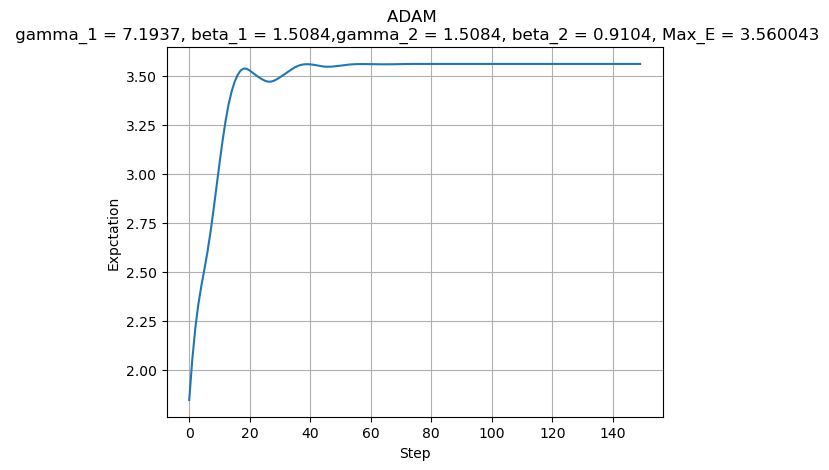

<BarContainer object of 16 artists>

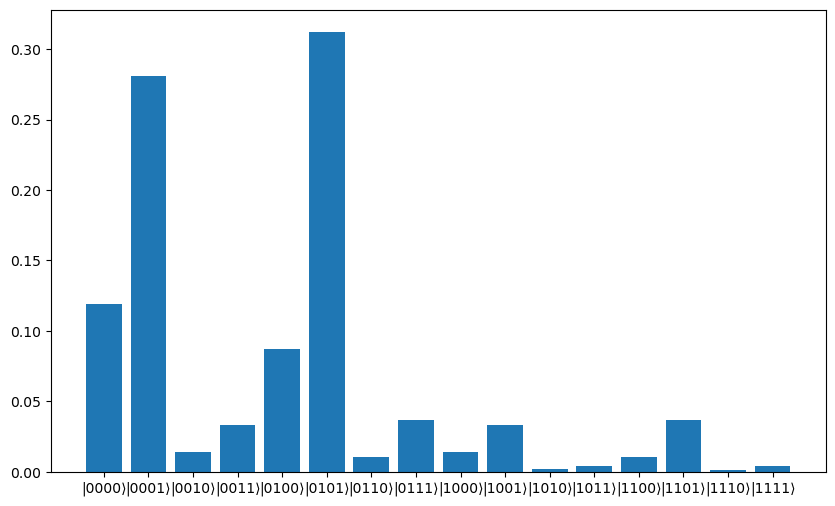

In [143]:
##拿到上面循环的最大E对应的初始参数，画函数曲线图
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
X = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#X = np.array([gamma_1, beta_1, gamma_2, beta_2]) #np.array([0.6499846869496124,0.8975979010256552,0.8666462492661499,0.6731984257692414])
#----ADAM的参数初始化
max_iter=150
epsilon = 1e-8 
gtol = 1e-8 #终止容差
alpha = 0.07 #学习率
beta1 = 0.9 #一阶矩估计的衰减率
beta2 = 0.999 #二阶矩估计的衰减率
m = np.zeros_like(X)  # 一阶矩估计
v = np.zeros_like(X)  # 二阶矩估计
#------------分割线----------------
lt_E = []
func = QC_func(Problem)
E = func(X)
for i in range(max_iter): 
    gradient = estimate_gradient_2(func,X)
    m = beta1 * m + (1 - beta1)*gradient
    v = beta2 * v + (1 - beta2) * gradient**2
    m_hat = m / (1 - beta1**(i+1))
    v_hat = v / (1 - beta2**(i+1))
    X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
    E_new = func(X)
    #if i % 20 == 0:
    #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
    #if np.abs(E_new - E) < gtol:
    #    break
    lt_E.append(E)
    E = E_new
X = X.round(4)
plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {},gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()

plt.savefig("E-curve_CSP_9_Adam_p2.jpg", bbox_inches = "tight")
plt.show()
model.updateQC([X[0],X[2]], X[[1]],p =1)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)

In [128]:
func = QC_func(Problem,True)
func

<function __main__.QC_func.<locals>.func(X)>

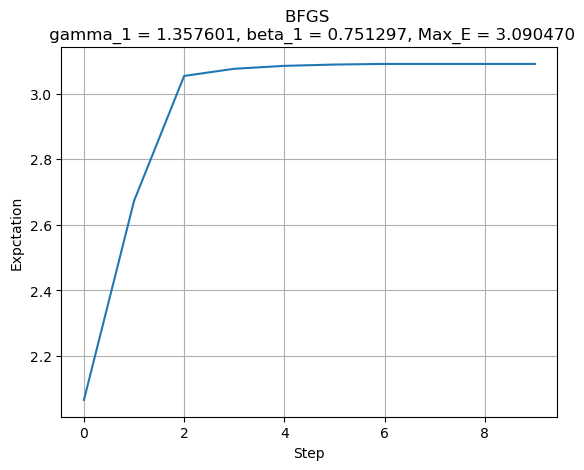

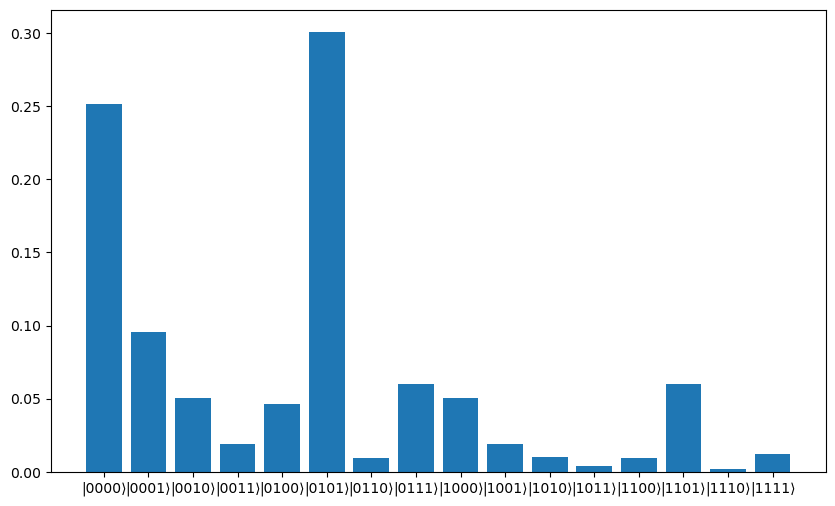

In [144]:
#BFSG 问题9
from scipy import optimize
E_maxlt = []
para_maxlt = []
for i in range(100):
    gamma_1 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_1 = np.random.uniform(0, np.pi)#参数初始化
    gamma_2 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_2 = np.random.uniform(0, np.pi)#参数初始化
    initial_guess = [gamma_1,beta_1,gamma_2,beta_2]
    bounds = [(0, 2*np.pi), (0, np.pi),(0, 2*np.pi),(0, np.pi)]
    lt_E = np.array([])
    def callback(x):
        global func
        loss = func(x)
        global lt_E
        lt_E = np.append(lt_E, loss)

    func = QC_func(Problem,True)
    model = CSP(Problem)
    HC = model.HC
    options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
    result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
    lt_E = -lt_E.round(6)
    E_maxlt.append(np.max(lt_E))
    para_maxlt.append(np.array([gamma_1, beta_1, gamma_2, beta_2]))

X = result.x
X = np.mod(X.round(6),2*np.pi)

plt.plot(lt_E)
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_9_BFGS.jpg", bbox_inches = "tight")
plt.show()

model.updateQC([X[0]], X[[1]],p =1)
#model.QC.dot(s)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
plt.savefig("bar-CSP_9_opt_BFGS.jpg", bbox_inches = "tight")

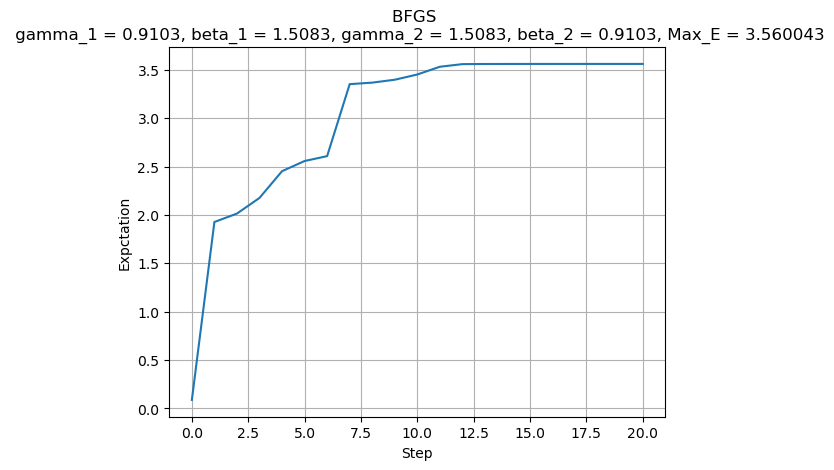

In [146]:
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
initial_guess = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#bounds = [(0, 2*np.pi), (0, np.pi)]
bounds = [(0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi)]
lt_E = np.array([])
func = QC_func(Problem,True)
model = CSP(Problem)
HC = model.HC
options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
lt_E = -lt_E.round(6)
X = result.x
X = np.mod(X,2*np.pi).round(4)
plt.plot(lt_E)
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_9_BFGS_p2.jpg", bbox_inches = "tight")
plt.show()

In [161]:
CtrlSeries = [1,0,1,-1,0,0,0,0,0,0,0,-1,0,0,0] #代表问题10
Power_1 = {"Z_1":CtrlSeries[0], "Z_2":CtrlSeries[1], "Z_3":CtrlSeries[2],"Z_4":CtrlSeries[3]}
Power_2 = {"Z_1 Z_2":CtrlSeries[4], "Z_3 Z_4":CtrlSeries[5],
        "Z_1 Z_3":CtrlSeries[6], "Z_1 Z_4":CtrlSeries[7], "Z_2 Z_3":CtrlSeries[8], "Z_2 Z_4":CtrlSeries[9]}
Power_3 = {"Z_1 Z_2 Z_3":CtrlSeries[10], "Z_1 Z_2 Z_4":CtrlSeries[11], "Z_1 Z_3 Z_4": CtrlSeries[12] , "Z_2 Z_3 Z_4":CtrlSeries[13]}
Power_4 = {"Z_1 Z_2 Z_3 Z_4":CtrlSeries[14]}
Problem_beta = {"Power_1":Power_1,
        "Power_2":Power_2,
        "Power_3":Power_3,
        "Power_4":Power_4}
Problem_alpha = create_new_dict(Problem_beta , modify_key_value)
Problem = (Problem_alpha,Problem_beta, Constant, factor)

In [203]:
len(np.where(np.array(E_maxlt)>1.78)[0])    

59

In [148]:
# ADAM优化 问题10
E_maxlt = []
for i in range(100):
    gamma_1 = np.random.uniform(0,2*np.pi) #参数初始化 1.3001062449119198
    beta_1 = np.random.uniform(0,np.pi) #参数初始化 1.0741995815915981
    gamma_2 = np.random.uniform(0,2*np.pi) #参数初始化 p=2
    beta_2 = np.random.uniform(0,np.pi) #参数初始化 p=2
    X = np.array([gamma_1, beta_1,gamma_2,beta_2])
    #----ADAM的参数初始化
    max_iter=150
    epsilon = 1e-8 
    gtol = 1e-8 #终止容差
    alpha = 0.07 #学习率
    beta1 = 0.9 #一阶矩估计的衰减率
    beta2 = 0.999 #二阶矩估计的衰减率
    m = np.zeros_like(X)  # 一阶矩估计
    v = np.zeros_like(X)  # 二阶矩估计
    #------------分割线----------------
    lt_E = []

    func = QC_func(Problem)
    model = CSP(Problem)
    HC = model.HC
    for i in range(max_iter): 
        gradient = estimate_gradient_2(func,X)
        m = beta1 * m + (1 - beta1)*gradient
        v = beta2 * v + (1 - beta2) * gradient**2
        m_hat = m / (1 - beta1**(i+1))
        v_hat = v / (1 - beta2**(i+1))
        X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
        E_new = func(X)
        #if i % 20 == 0:
        #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
        #if np.abs(E_new - E) < gtol:
        #    break
        lt_E.append(E_new)
        E = E_new
    E_maxlt.append(np.max(lt_E))
X = np.mod(X,2*np.pi).round(6)
""" plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()

plt.savefig("E-curve_CSP_10_Adam_p2.jpg", bbox_inches = "tight")
plt.show()
model.updateQC([X[0]], X[[1]],p =1)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
plt.savefig("bar-CSP_10_opt_Adam_p2.jpg", bbox_inches = "tight") """

' plt.plot(lt_E)\nplt.title("ADAM \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(E)))\nplt.xlabel("Step")\nplt.ylabel("Expctation")\nplt.grid()\n\nplt.savefig("E-curve_CSP_10_Adam_p2.jpg", bbox_inches = "tight")\nplt.show()\nmodel.updateQC([X[0]], X[[1]],p =1)\nState = getBaseProb(model.QC.dot(s))\nXlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]\nplt.figure(figsize=(10,6))\nplt.bar(Xlabel,State.real)\nplt.savefig("bar-CSP_10_opt_Adam_p2.jpg", bbox_inches = "tight") '

In [ ]:
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
X = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#X = np.array([gamma_1, beta_1, gamma_2, beta_2]) #np.array([0.6499846869496124,0.8975979010256552,0.8666462492661499,0.6731984257692414])
#----ADAM的参数初始化
max_iter=150
epsilon = 1e-8 
gtol = 1e-8 #终止容差
alpha = 0.07 #学习率
beta1 = 0.9 #一阶矩估计的衰减率
beta2 = 0.999 #二阶矩估计的衰减率
m = np.zeros_like(X)  # 一阶矩估计
v = np.zeros_like(X)  # 二阶矩估计
#------------分割线----------------
lt_E = []
func = QC_func(Problem)
E = func(X)
for i in range(max_iter): 
    gradient = estimate_gradient_2(func,X)
    m = beta1 * m + (1 - beta1)*gradient
    v = beta2 * v + (1 - beta2) * gradient**2
    m_hat = m / (1 - beta1**(i+1))
    v_hat = v / (1 - beta2**(i+1))
    X += alpha * m_hat / (np.sqrt(v_hat) + epsilon) 
    E_new = func(X)
    #if i % 20 == 0:
    #    print("Total=200, i = {}, E = {}, gamma = {}, beta = {}".format(i,E,X[0],X[1]))
    #if np.abs(E_new - E) < gtol:
    #    break
    lt_E.append(E)
    E = E_new
X = X.round(4)
plt.plot(lt_E)
plt.title("ADAM \n gamma_1 = {}, beta_1 = {},gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_10_Adam_p2.jpg", bbox_inches = "tight")
plt.show()

In [169]:
len(np.where(np.array(E_maxlt)>3.11)[0])    

27

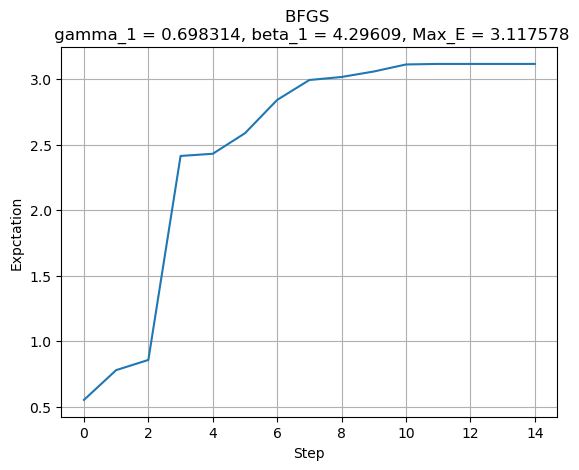

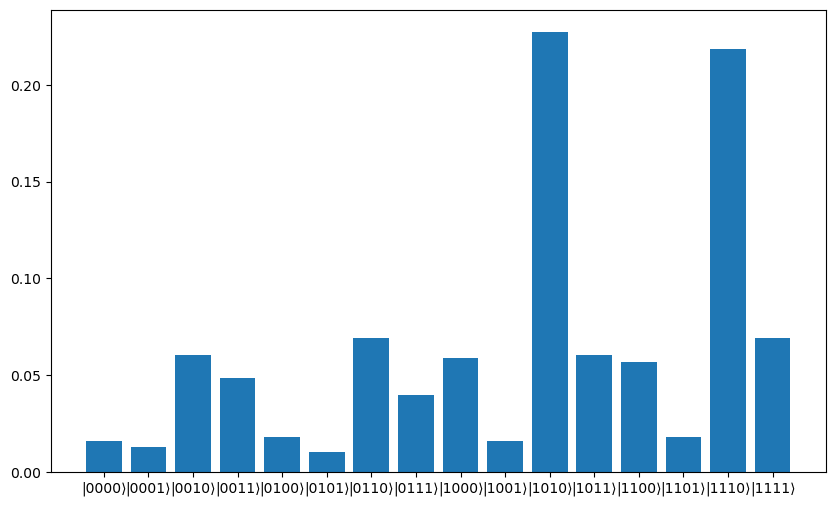

In [162]:
#BFSG 问题10
func = QC_func(Problem,True)
from scipy import optimize
E_maxlt = []
para_maxlt = []
for i in range(100):
    gamma_1 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_1 = np.random.uniform(0, np.pi)#参数初始化
    gamma_2 = np.random.uniform(0, 2*np.pi)#参数初始化
    beta_2 = np.random.uniform(0, np.pi)#参数初始化
    initial_guess = [gamma_1,beta_1,gamma_2,beta_2]
    bounds = [(0, 2*np.pi), (0, np.pi),(0, 2*np.pi),(0, np.pi)]
    lt_E = np.array([])
    def callback(x):
        global func
        loss = func(x)
        global lt_E
        lt_E = np.append(lt_E, loss)

    model = CSP(Problem)
    HC = model.HC
    options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
    result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
    lt_E = -lt_E.round(6)
    E_maxlt.append(np.max(lt_E))
    para_maxlt.append(np.array([gamma_1, beta_1, gamma_2, beta_2]))

X = result.x
X = np.mod(X.round(6),2*np.pi)

plt.plot(lt_E)
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, Max_E = {:.6f}".format(X[0],X[1],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_10_BFGS.jpg", bbox_inches = "tight")
plt.show()

model.updateQC([X[0]], X[[1]],p =1)
#model.QC.dot(s)
State = getBaseProb(model.QC.dot(s))
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
plt.savefig("bar-CSP_10_opt_BFGS.jpg", bbox_inches = "tight")

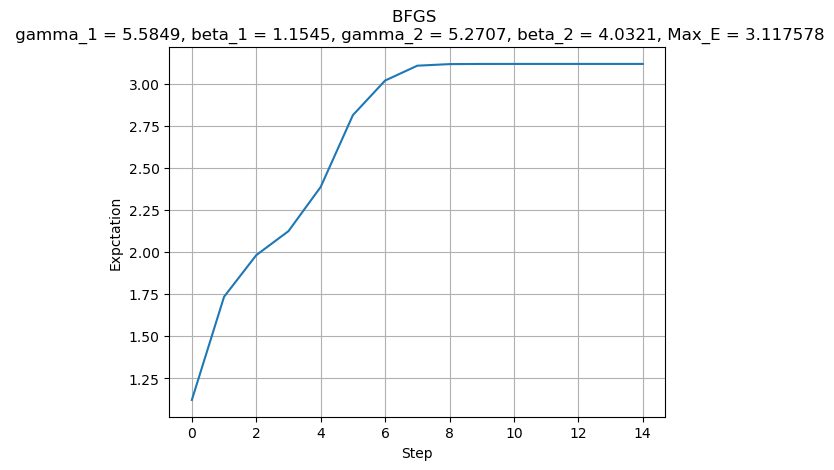

In [159]:
df_tmp = pd.DataFrame(data = {"E":E_maxlt,"para":para_maxlt}) #拿到上面循环的最大E对应的初始参数，画函数曲线图
initial_guess = df_tmp.sort_values("E",ascending = False).iloc[0,1].copy()
#bounds = [(0, 2*np.pi), (0, np.pi)]
bounds = [(0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi)]
lt_E = np.array([])
func = QC_func(Problem,True)
model = CSP(Problem)
HC = model.HC
options = {'gtol': 1e-8, 'eps': 1e-5} #终止容差，梯度增量
result = optimize.minimize(func, initial_guess, method='BFGS' , callback=callback,options=options)
lt_E = -lt_E.round(6)
X = result.x
X = np.mod(X,2*np.pi).round(4)
plt.plot(lt_E)
plt.title("BFGS \n gamma_1 = {}, beta_1 = {}, gamma_2 = {}, beta_2 = {}, Max_E = {:.6f}".format(X[0],X[1],X[2],X[3],np.max(lt_E)))
plt.xlabel("Step")
plt.ylabel("Expctation")
plt.grid()
plt.savefig("E-curve_CSP_10_BFGS_p2.jpg", bbox_inches = "tight")
plt.show()